# Dependencies

In [1]:
!pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from skforecast.recursive import ForecasterRecursive
from sklearn.linear_model import LinearRegression

# Load Dataset

In [3]:
# Load dataset
df = pd.read_csv('input.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


# Preprocessing

In [4]:
# Drop unnecessary columns
df = df.drop(['UDI'], axis=1)
df = df.drop(['Product ID'], axis=1)
df = df.drop(['Type'], axis=1)
df = df.drop(['Target'], axis=1)
df = df.drop(['Failure Type'], axis=1)
df.columns

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'],
      dtype='object')

In [5]:
df = df.rename(columns={'Air temperature [K]': 'Air temperature',
                                'Process temperature [K]': 'Process temperature',
                                'Rotational speed [rpm]': 'Rotational speed',
                                'Torque [Nm]': 'Torque',
                                'Tool wear [min]': 'Tool wear',
                                })
df.columns

Index(['Air temperature', 'Process temperature', 'Rotational speed', 'Torque',
       'Tool wear'],
      dtype='object')

In [6]:
residual_df = None

def evaluate_model(model, y_test_ori, y_test_smooth):
    steps = 50
    y_pred = model.predict(steps=steps)

    mae_ori = mean_absolute_error(y_test_ori, y_pred)
    mse_ori = mean_squared_error(y_test_ori, y_pred)
    r2_ori = r2_score(y_test_ori, y_pred)

    mae_smooth = mean_absolute_error(y_test_smooth, y_pred)
    mse_smooth = mean_squared_error(y_test_smooth, y_pred)
    r2_smooth = r2_score(y_test_smooth, y_pred)

    results_data = {
        '': ['MAE', 'MSE', 'R^2'],
        'Ori': [mae_ori, mse_ori, r2_ori],
        'Smoothed': [mae_smooth, mse_smooth, r2_smooth],
    }

    results_df = pd.DataFrame(results_data)
    print(results_df.to_string(index=False))

In [7]:
def detect_outliers_iqr(df, column):    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Air temperature Forecasting

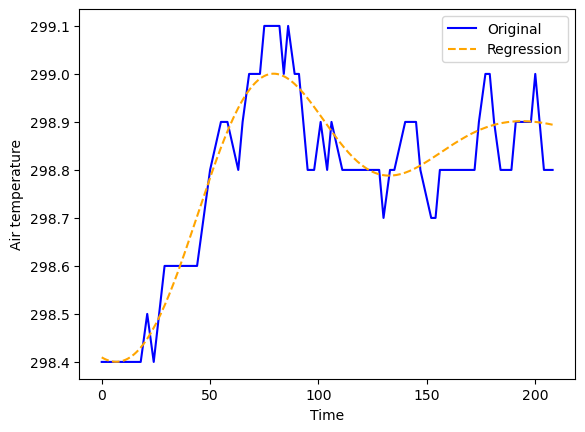

MAE:  0.048682183009925314


In [8]:
df = df.set_index("Tool wear")
full_index = pd.Index(range(df.index.max() + 1), name="Tool wear")
df = df.reindex(full_index)

_, lower_bound, upper_bound = detect_outliers_iqr(df, "Air temperature")
df.loc[df["Air temperature"] < lower_bound, 'Air temperature'] = lower_bound
df.loc[df["Air temperature"] > upper_bound, 'Air temperature'] = upper_bound

df["Air temperature"] = df["Air temperature"].interpolate()
df = df.reset_index(drop=True)
x = pd.DataFrame(list(df.index), columns=["Index"])
y = df["Air temperature"]

svr = SVR(kernel='rbf')
svr.fit(x, y)
y_pred = svr.predict(x)

plt.plot(y, label='Original', color='blue')
plt.plot(y_pred, label=f'Regression', linestyle='--', color='orange')
plt.xlabel('Time')
plt.ylabel('Air temperature')
plt.legend()
plt.show()

mae = mean_absolute_error(y, y_pred)
print("MAE: ", mae)

In [9]:
train = y_pred[:-50]
test_ori = y[-50:]
test_smooth = y_pred[-50:]

forecaster = ForecasterRecursive(
                 regressor = LinearRegression(),
                 lags      = 1
             )
forecaster.fit(y=pd.Series(train, name="Air temperature"))
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LinearRegression 
Lags: [1] 
Window features: None 
Window size: 1 
Series name: Air temperature 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [0, 158] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False} 
fit_kwargs: {} 
Creation date: 2025-10-28 22:17:50 
Last fit date: 2025-10-28 22:17:50 
Skforecast version: 0.18.0 
Python version: 3.12.7 
Forecaster id: None

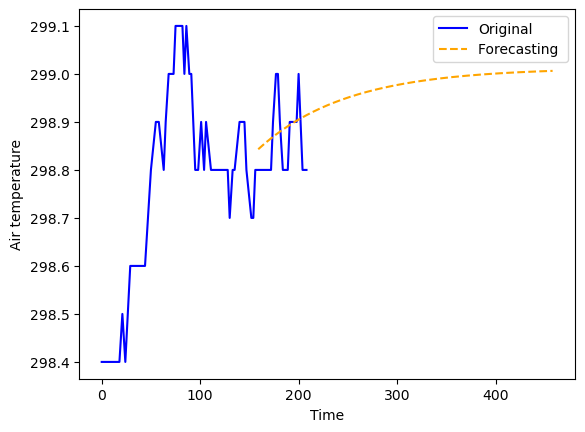

In [10]:
steps = 300
predictions = forecaster.predict(steps=steps)
predictions[predictions < 294] = 294
predictions[predictions > 306] = 306

plt.plot(y, label='Original', color='blue')
plt.plot(predictions, label=f'Forecasting ', linestyle='--', color='orange')

plt.xlabel('Time')
plt.ylabel('Air temperature')
plt.legend()
plt.show()

In [11]:
evaluate_model(forecaster, test_ori, test_smooth)

          Ori  Smoothed
MAE  0.058037  0.009599
MSE  0.004773  0.000115
R^2 -0.047043  0.600567


In [12]:
predictions = predictions.rename('Air temperature')
output_df = pd.DataFrame(predictions)
output_df

,Air temperature
159,298.843070
160,298.844937
161,298.846783
162,298.848609
163,298.850415
...,...
454,299.006074
455,299.006145
456,299.006216
457,299.006285


# Process temperature Forecasting

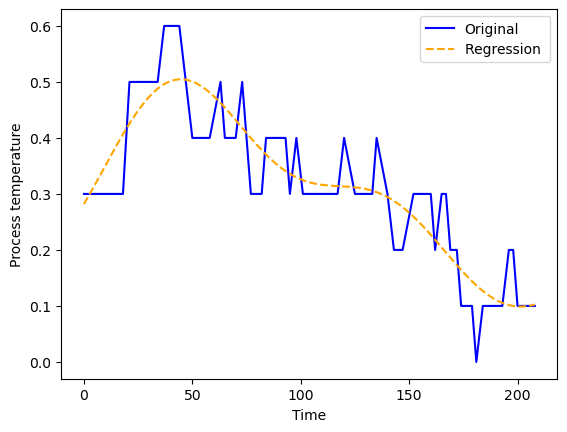

MAE:  0.04485484182306037


In [13]:
_, lower_bound, upper_bound = detect_outliers_iqr(df, "Process temperature")
df.loc[df["Process temperature"] < lower_bound, 'Process temperature'] = lower_bound
df.loc[df["Process temperature"] > upper_bound, 'Process temperature'] = upper_bound

process_temperature_ori = df["Process temperature"] - df["Air temperature"] - 10
df["Process temperature"] = process_temperature_ori.interpolate()
x = pd.DataFrame(list(df.index), columns=["Index"])
y = df["Process temperature"]

svr = SVR(kernel='rbf')
svr.fit(x, y)
y_pred = svr.predict(x)

plt.plot(y, label='Original', color='blue')
plt.plot(y_pred, label=f'Regression ', linestyle='--', color='orange')
plt.xlabel('Time')
plt.ylabel('Process temperature')
plt.legend()
plt.show()

mae = mean_absolute_error(y, y_pred)
print("MAE: ", mae)

In [14]:
train = y_pred[:-50]
test_ori = y[-50:]
test_smooth = y_pred[-50:]

forecaster = ForecasterRecursive(
                 regressor = LinearRegression(),
                 lags      = 1
             )
forecaster.fit(y=pd.Series(train, name="Process temperature"))
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LinearRegression 
Lags: [1] 
Window features: None 
Window size: 1 
Series name: Process temperature 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [0, 158] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False} 
fit_kwargs: {} 
Creation date: 2025-10-28 22:17:51 
Last fit date: 2025-10-28 22:17:51 
Skforecast version: 0.18.0 
Python version: 3.12.7 
Forecaster id: None

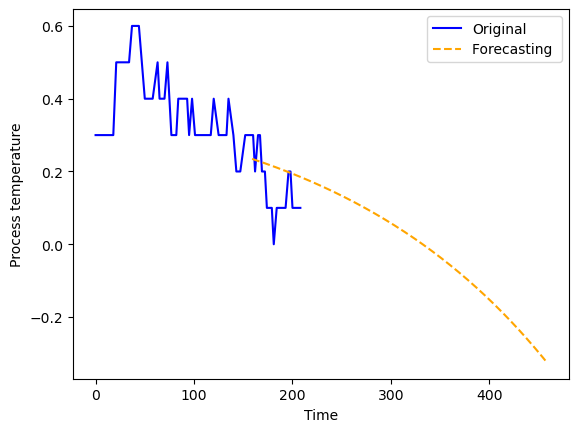

In [15]:
steps = 300
predictions = forecaster.predict(steps=steps)
predictions[predictions < -3] = -3
predictions[predictions > 3] = 3

plt.plot(y, label='Original', color='blue')
plt.plot(predictions, label=f'Forecasting ', linestyle='--', color='orange')

plt.xlabel('Time')
plt.ylabel('Process temperature')
plt.legend()
plt.show()

In [16]:
evaluate_model(forecaster, test_ori, test_smooth)

          Ori  Smoothed
MAE  0.081155  0.068340
MSE  0.008741  0.005523
R^2 -0.513694 -2.033998


In [17]:
predictions = predictions.values + output_df["Air temperature"].values + 10
predictions = pd.Series(predictions, name='Process temperature', index=output_df.index)
output_df = pd.concat([output_df, predictions], axis=1)
output_df

,Air temperature,Process temperature
159,298.843070,309.077724
160,298.844937,309.078681
161,298.846783,309.079615
162,298.848609,309.080524
163,298.850415,309.081408
...,...,...
454,299.006074,308.696013
455,299.006145,308.692796
456,299.006216,308.689563
457,299.006285,308.686315


# Rotational speed Forecasting

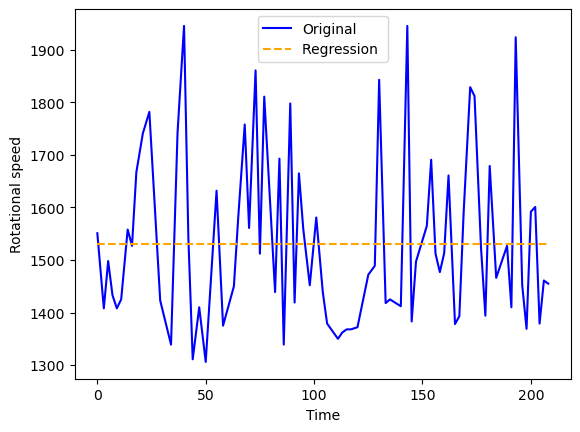

MAE:  113.58886548690126


In [18]:
_, lower_bound, upper_bound = detect_outliers_iqr(df, "Rotational speed")
df.loc[df["Rotational speed"] < lower_bound, 'Rotational speed'] = lower_bound
df.loc[df["Rotational speed"] > upper_bound, 'Rotational speed'] = upper_bound

df["Rotational speed"] = df["Rotational speed"].interpolate()
y = df["Rotational speed"]
y_pred = np.mean(y) * np.ones_like(y)

plt.plot(y, label='Original', color='blue')
plt.plot(y_pred, label=f'Regression ', linestyle='--', color='orange')
plt.xlabel('Time')
plt.ylabel('Rotational speed')
plt.legend()
plt.show()

mae = mean_absolute_error(y, y_pred)
print("MAE: ", mae)

In [19]:
train = y_pred[:-50]
test_ori = y[-50:]
test_smooth = y_pred[-50:]

forecaster = ForecasterRecursive(
                 regressor = LinearRegression(),
                 lags      = 1
             )
forecaster.fit(y=pd.Series(train, name="Rotational speed"))
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LinearRegression 
Lags: [1] 
Window features: None 
Window size: 1 
Series name: Rotational speed 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [0, 158] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False} 
fit_kwargs: {} 
Creation date: 2025-10-28 22:25:08 
Last fit date: 2025-10-28 22:25:08 
Skforecast version: 0.18.0 
Python version: 3.12.7 
Forecaster id: None

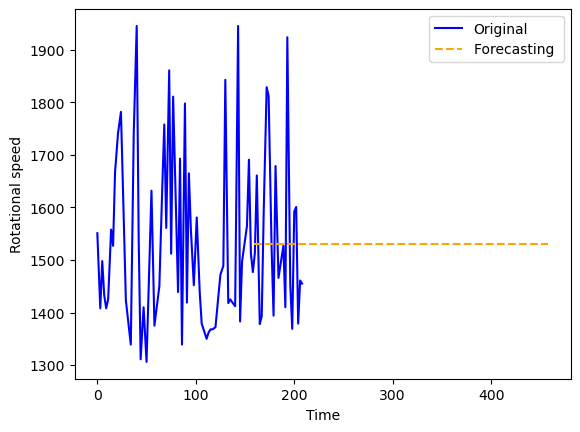

In [20]:
steps = 300
predictions = forecaster.predict(steps=steps)

plt.plot(y, label='Original', color='blue')
plt.plot(predictions, label=f'Forecasting ', linestyle='--', color='orange')

plt.xlabel('Time')
plt.ylabel('Rotational speed')
plt.legend()
plt.show()

In [21]:
evaluate_model(forecaster, test_ori, test_smooth)

             Ori  Smoothed
MAE   103.732145       0.0
MSE 17754.594180       0.0
R^2    -0.020996       1.0


In [22]:
predictions = predictions.rename('Rotational speed')
output_df = pd.concat([output_df, predictions], axis=1)
output_df

,Air temperature,Process temperature,Rotational speed
159,298.843070,309.077724,1530.462321
160,298.844937,309.078681,1530.462321
161,298.846783,309.079615,1530.462321
162,298.848609,309.080524,1530.462321
163,298.850415,309.081408,1530.462321
...,...,...,...
454,299.006074,308.696013,1530.462321
455,299.006145,308.692796,1530.462321
456,299.006216,308.689563,1530.462321
457,299.006285,308.686315,1530.462321


# Torque Forecasting

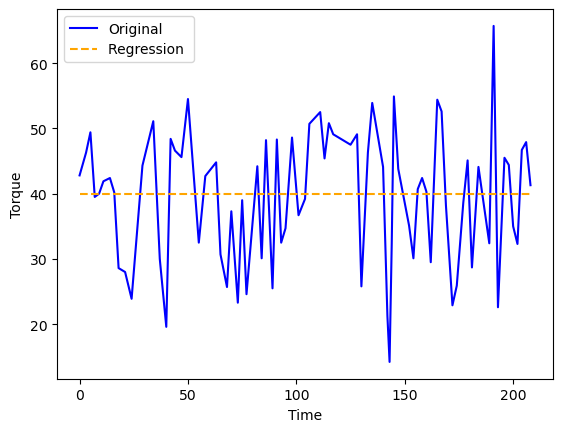

In [24]:
_, lower_bound, upper_bound = detect_outliers_iqr(df, "Torque")
df.loc[df["Torque"] < lower_bound, 'Torque'] = lower_bound
df.loc[df["Torque"] > upper_bound, 'Torque'] = upper_bound

df["Torque"] = df["Torque"].interpolate()
y = df["Torque"]
y_pred = 40 * np.ones_like(y)

plt.plot(y, label='Original', color='blue')
plt.plot(y_pred, label=f'Regression ', linestyle='--', color='orange')
plt.xlabel('Time')
plt.ylabel('Torque')
plt.legend()
plt.show()

In [25]:
train = y_pred[:-50]
test_ori = y[-50:]
test_smooth = y_pred[-50:]

forecaster = ForecasterRecursive(
                 regressor = LinearRegression(),
                 lags      = 1
             )
forecaster.fit(y=pd.Series(train, name="Torque"))
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LinearRegression 
Lags: [1] 
Window features: None 
Window size: 1 
Series name: Torque 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [0, 158] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False} 
fit_kwargs: {} 
Creation date: 2025-10-28 22:29:54 
Last fit date: 2025-10-28 22:29:54 
Skforecast version: 0.18.0 
Python version: 3.12.7 
Forecaster id: None

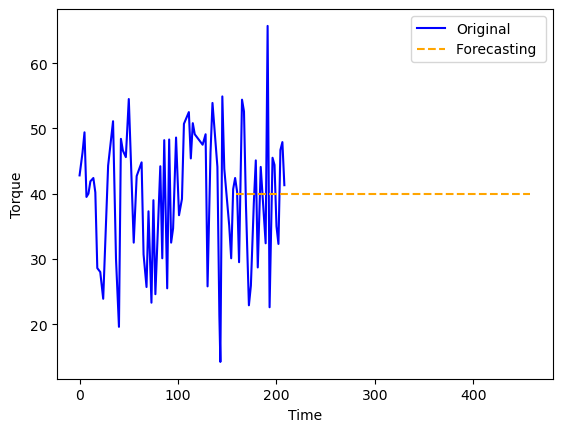

In [26]:
steps = 300
predictions = forecaster.predict(steps=steps)
predictions[predictions < 0] = 0

plt.plot(y, label='Original', color='blue')
plt.plot(predictions, label=f'Forecasting ', linestyle='--', color='orange')

plt.xlabel('Time')
plt.ylabel('Torque')
plt.legend()
plt.show()

In [27]:
evaluate_model(forecaster, test_ori, test_smooth)

          Ori  Smoothed
MAE  6.746400       0.0
MSE 73.661460       0.0
R^2 -0.009349       1.0


In [28]:
predictions = predictions.rename('Torque')
output_df = pd.concat([output_df, predictions], axis=1)
output_df

,Air temperature,Process temperature,Rotational speed,Torque
159,298.843070,309.077724,1530.462321,40.0
160,298.844937,309.078681,1530.462321,40.0
161,298.846783,309.079615,1530.462321,40.0
162,298.848609,309.080524,1530.462321,40.0
163,298.850415,309.081408,1530.462321,40.0
...,...,...,...,...
454,299.006074,308.696013,1530.462321,40.0
455,299.006145,308.692796,1530.462321,40.0
456,299.006216,308.689563,1530.462321,40.0
457,299.006285,308.686315,1530.462321,40.0


# Save CSV

In [29]:
indices = list(output_df.index)
indices = pd.Series(indices, name='Tool wear', index=output_df.index)
output_df = pd.concat([output_df, indices], axis=1)
output_df = output_df.reset_index(drop=True)
output_df.to_csv('forecaster_output.csv', index=False)
output_df

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear
0,298.843070,309.077724,1530.462321,40.0,159
1,298.844937,309.078681,1530.462321,40.0,160
2,298.846783,309.079615,1530.462321,40.0,161
3,298.848609,309.080524,1530.462321,40.0,162
4,298.850415,309.081408,1530.462321,40.0,163
...,...,...,...,...,...
295,299.006074,308.696013,1530.462321,40.0,454
296,299.006145,308.692796,1530.462321,40.0,455
297,299.006216,308.689563,1530.462321,40.0,456
298,299.006285,308.686315,1530.462321,40.0,457
